In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow_datasets as tfds
tfkl = tfk.layers
from tensorflow.keras.models import Sequential

## 1.

In [2]:
# load the CIFAR10 dataset
data, info = tfds.load('cifar10', with_info=True)
print(info)

tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)



In [3]:
preprocess = lambda d: (tf.cast(d['image'], tf.float32)/255., d['label'])
df_train = data['train'].map(preprocess).map(lambda x, y: (x, x)).cache().batch(32).repeat().prefetch(5)
df_test = data['test'].map(preprocess)

In [4]:
img_shape = info.features['image'].shape
print(img_shape)
print(np.prod(img_shape))

(32, 32, 3)
3072


In [5]:
encoder = tfk.Sequential([
    tfkl.InputLayer(img_shape),
    tfkl.Conv2D(32,(3,3), activation=tf.nn.relu, padding="same"),
    tfkl.MaxPooling2D((2,2), padding="same"),
    tfkl.Conv2D(16,(3,3), activation=tf.nn.relu, padding="same"),
    tfkl.MaxPooling2D((2,2), padding="same"),
    tfkl.Conv2D(16, (3, 3), activation=tf.nn.relu, padding="same"),
    tfkl.MaxPooling2D((2,2), padding="same")
])

encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 16)          2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 16)          0         
Total params: 7,840
Trainable params: 7,840
Non-trainable params: 0
______________________________________________________

In [6]:
decoder = tfk.Sequential([
    tfkl.InputLayer((4, 4, 16)),
    tfkl.Conv2D(16,(3, 3), activation=tf.nn.relu, padding="same"),
    tfkl.UpSampling2D((2, 2)),
    tfkl.Conv2D(16, (3, 3), activation=tf.nn.relu, padding="same"),
    tfkl.UpSampling2D((2, 2)),
    tfkl.Conv2D(32, (3, 3), activation=tf.nn.relu, padding="same"),
    tfkl.UpSampling2D((2, 2)),
    tfkl.Conv2D(3, (3, 3), activation=tf.nn.relu, padding="same")
])

decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 4, 4, 16)          2320      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 16)          2320      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 3)        

In [7]:
# the tf.keras function API starts with defining placeholder tensors that represent model inputs
x = tfkl.Input(img_shape)


# we can then pass this placeholder through our models to specify the computation to get a prediction
h = encoder(x)
xhat = decoder(h)

# finally we use the tfk.Model class instantiate the model by specifying the inputs and outputs
# (note: this can also be lists, which is how you make more complex models with multiple inputs and/or outputs)
autoencoder = tfk.Model(inputs=x, outputs=xhat)
autoencoder.summary()

# training happens as usual
autoencoder.compile(
    optimizer=tfk.optimizers.Adam(),
    loss=tfk.losses.BinaryCrossentropy(),
)

results = autoencoder.fit(df_train, steps_per_epoch=400, epochs=10)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 4, 4, 16)          7840      
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 3)         10147     
Total params: 17,987
Trainable params: 17,987
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
400/400 [==============================] - 29s 73ms/step - loss: 0.6804
Epoch 2/10
400/400 [==============================] - 27s 68ms/step - loss: 0.6095
Epoch 3/10
400/400 [==============================] - 26s 66ms/step - loss: 0.6079
Epoch 4/10
400/400 [==============================] - 28s 69ms/step - loss: 0.5996
Epoch 5/10
400/400 [============================

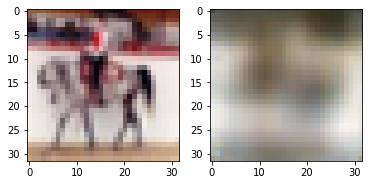

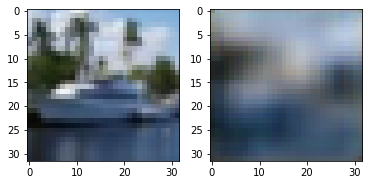

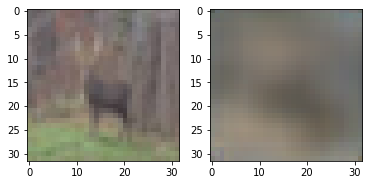

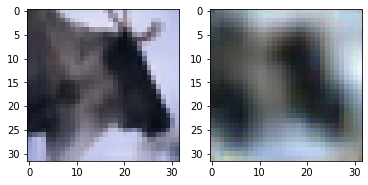

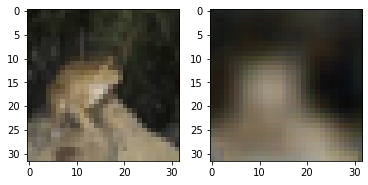

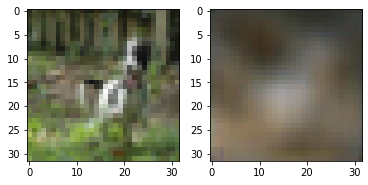

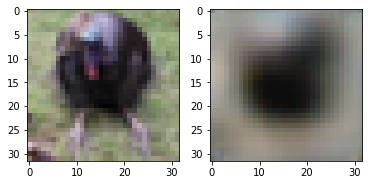

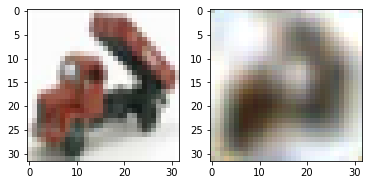

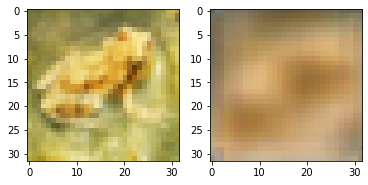

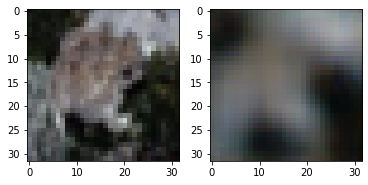

In [8]:
imgs = next(iter(df_train))[0]
for i in range(10):
    plt.subplot(1, 2, 1)
    plt.imshow(imgs[i].numpy().squeeze(), cmap='bone')
    plt.subplot(1, 2, 2, )
    plt.imshow(autoencoder(imgs[i][tf.newaxis]).numpy().squeeze(), cmap='bone')
    plt.show()

## 2.1

Choose the architecture whose kernel size equals 2, strides equals 1, padding is valid and network depth is 8.

In [9]:
model = tfk.Sequential([
    tfkl.InputLayer(img_shape),
    tfkl.Conv2D(filters = 32, kernel_size= 2, strides= 1, padding= "valid",
                           activation = 'relu'),
    tfkl.MaxPooling2D((2, 2)),
    tfkl.Conv2D(filters = 64, kernel_size= 2, strides= 1, padding= "valid", activation= 'relu'),
    tfkl.MaxPooling2D((2, 2)),
    tfkl.Conv2D(filters = 64, kernel_size= 2, strides= 1, padding= "valid", activation= 'relu'),
    tfkl.Flatten(),
    tfkl.Dense(64, activation= 'relu'),
    tfkl.Dense(10, activation="softmax")
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 31, 31, 32)        416       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 6, 6, 64)          16448     
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 64)               

In [10]:
preprocess = lambda d: (tf.cast(d["image"], tf.float32)/255, tf.one_hot(d["label"], depth=10))

ds_train = data['train'].map(preprocess).cache().batch(8)
ds_test = data["test"].map(preprocess).cache().batch(8)

In [11]:
# compile and train the model
model.compile(optimizer=tfk.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


history = model.fit(ds_train, epochs=10, validation_data=(ds_test))

Epoch 1/10
6250/6250 [==============================] - 49s 8ms/step - loss: 1.4185 - accuracy: 0.4877 - val_loss: 1.1535 - val_accuracy: 0.5909
Epoch 2/10
6250/6250 [==============================] - 45s 7ms/step - loss: 1.0581 - accuracy: 0.6305 - val_loss: 1.0292 - val_accuracy: 0.6408
Epoch 3/10
6250/6250 [==============================] - 40s 6ms/step - loss: 0.9194 - accuracy: 0.6778 - val_loss: 0.9799 - val_accuracy: 0.6640
Epoch 4/10
6250/6250 [==============================] - 41s 7ms/step - loss: 0.8290 - accuracy: 0.7082 - val_loss: 0.9624 - val_accuracy: 0.6751
Epoch 5/10
6250/6250 [==============================] - 40s 6ms/step - loss: 0.7549 - accuracy: 0.7337 - val_loss: 1.0082 - val_accuracy: 0.6637
Epoch 6/10
6250/6250 [==============================] - 41s 6ms/step - loss: 0.6870 - accuracy: 0.7598 - val_loss: 1.0038 - val_accuracy: 0.6697
Epoch 7/10
6250/6250 [==============================] - 50s 8ms/step - loss: 0.6296 - accuracy: 0.7797 - val_loss: 1.0346 - val_ac

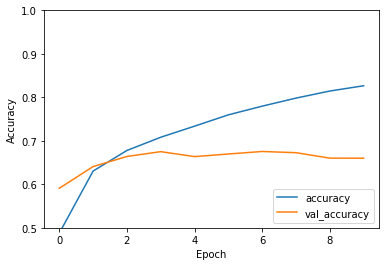

In [12]:
# evaluate the model
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [13]:
test_loss, test_acc = model.evaluate(ds_test,verbose=2)
print('\nTest accuracy:', test_acc)

1250/1250 - 3s - loss: 1.2304 - accuracy: 0.6600

Test accuracy: 0.6600000262260437


## 2.2

In [14]:
# Choose MobileNetV2
base_model = tfk.applications.MobileNetV2(input_shape=(32, 32, 3),
                                include_top=False,
                                weights='imagenet')
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 33, 33, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 16, 16, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 16, 16, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [15]:
base_model.trainable = False

In [16]:
image_batch = tfk.Input(shape=(32,32,3))
feature_batch = base_model(image_batch)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
prediction_layer = tfkl.Dense(10, activation="softmax")
outputs = prediction_layer(feature_batch_average)

In [17]:
model2 = tfk.Model(image_batch, outputs)

In [18]:
base_learning_rate = 0.0001
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
history2 = model2.fit(ds_train, epochs=10, validation_data=ds_test)


Epoch 1/10
6250/6250 [==============================] - 59s 9ms/step - loss: 0.7329 - accuracy: 0.2096 - val_loss: 0.7315 - val_accuracy: 0.2449
Epoch 2/10
6250/6250 [==============================] - 58s 9ms/step - loss: 0.7304 - accuracy: 0.2552 - val_loss: 0.7295 - val_accuracy: 0.2690
Epoch 3/10
6250/6250 [==============================] - 58s 9ms/step - loss: 0.7288 - accuracy: 0.2786 - val_loss: 0.7281 - val_accuracy: 0.2815
Epoch 4/10
6250/6250 [==============================] - 58s 9ms/step - loss: 0.7276 - accuracy: 0.2889 - val_loss: 0.7272 - val_accuracy: 0.2895
Epoch 5/10
6250/6250 [==============================] - 60s 10ms/step - loss: 0.7267 - accuracy: 0.2948 - val_loss: 0.7264 - val_accuracy: 0.2926
Epoch 6/10
6250/6250 [==============================] - 59s 9ms/step - loss: 0.7260 - accuracy: 0.2992 - val_loss: 0.7258 - val_accuracy: 0.2954
Epoch 7/10
6250/6250 [==============================] - 58s 9ms/step - loss: 0.7254 - accuracy: 0.3019 - val_loss: 0.7254 - val_a

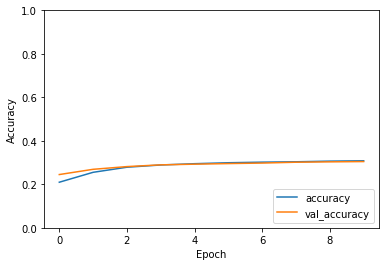

In [20]:
# evaluate the model
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')

In [21]:
test_loss, test_acc = model2.evaluate(ds_test,verbose=2)
print('\nTest accuracy:', test_acc)

1250/1250 - 9s - loss: 0.7243 - accuracy: 0.3046

Test accuracy: 0.3046000003814697


## 3.1

In [22]:
df = pd.read_csv("SPAM_detection.csv")
df.head()

,Message,category_val
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [23]:
text = df['Message'].str.lower()
chars = sorted(list(set(text)))
print('total chars:', len(chars))

total chars: 5156


In [24]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

cv = CountVectorizer(stop_words="english", max_features = 1000)
X = cv.fit_transform(text).toarray()
Y = df["category_val"].values
X = X[:,:,None]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [25]:
model3 = tfk.Sequential()
model3.add(tfkl.GRU(32,input_shape = X_train.shape[1:]))
model3.add(tfkl.Dense(8, activation="relu"))
model3.add(tfkl.Dense(1, activation="sigmoid"))
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 32)                3360      
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 3,633
Trainable params: 3,633
Non-trainable params: 0
_________________________________________________________________


In [26]:
model3.compile(optimizer=tfk.optimizers.Adam(), 
               loss=tfk.losses.BinaryCrossentropy(),
               metrics=["accuracy"])

In [27]:
model3.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
140/140 [==============================] - 40s 287ms/step - loss: 0.4480 - accuracy: 0.8663 - val_loss: 0.3938 - val_accuracy: 0.8664
Epoch 2/10
140/140 [==============================] - 38s 269ms/step - loss: 0.3970 - accuracy: 0.8658 - val_loss: 0.3937 - val_accuracy: 0.8664
Epoch 3/10
140/140 [==============================] - 35s 253ms/step - loss: 0.3974 - accuracy: 0.8658 - val_loss: 0.3932 - val_accuracy: 0.8664
Epoch 4/10
140/140 [==============================] - 36s 256ms/step - loss: 0.3946 - accuracy: 0.8658 - val_loss: 0.3932 - val_accuracy: 0.8664
Epoch 5/10
140/140 [==============================] - 37s 262ms/step - loss: 0.3952 - accuracy: 0.8658 - val_loss: 0.3930 - val_accuracy: 0.8664
Epoch 6/10
140/140 [==============================] - 36s 258ms/step - loss: 0.3948 - accuracy: 0.8658 - val_loss: 0.3932 - val_accuracy: 0.8664
Epoch 7/10
140/140 [==============================] - 36s 258ms/step - loss: 0.3947 - accuracy: 0.8658 - val_loss: 0.3925 - val_ac

## 3.2

In [28]:
model4 = tfk.Sequential([
    tfkl.Conv1D(filters= 32,kernel_size= 2,strides= 1,padding='valid',input_shape= (X_train.shape[1:]),
                activation= 'relu'),
    tfkl.MaxPooling1D(pool_size = 2),
    tfkl.Conv1D(filters = 64, kernel_size= 2,strides= 1,padding='valid', activation= 'relu'),
    tfkl.Flatten(),
    tfkl.Dense(64,activation='relu'),
    tfkl.Dense(1,activation='sigmoid')                     
])

model4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 999, 32)           96        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 499, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 498, 64)           4160      
_________________________________________________________________
flatten_1 (Flatten)          (None, 31872)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                2039872   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 2,044,193
Trainable params: 2,044,193
Non-trainable params: 0
____________________________________________

In [29]:
model4.compile(optimizer=tfk.optimizers.Adam(),
               loss=tfk.losses.BinaryCrossentropy(),
               metrics=["accuracy"])

In [30]:
model4.fit(X_train,y_train, epochs = 10, validation_data=(X_test,y_test))

Epoch 1/10
140/140 [==============================] - 5s 32ms/step - loss: 0.1263 - accuracy: 0.9589 - val_loss: 0.0589 - val_accuracy: 0.9874
Epoch 2/10
140/140 [==============================] - 4s 28ms/step - loss: 0.0478 - accuracy: 0.9852 - val_loss: 0.0758 - val_accuracy: 0.9767
Epoch 3/10
140/140 [==============================] - 4s 29ms/step - loss: 0.0276 - accuracy: 0.9915 - val_loss: 0.0637 - val_accuracy: 0.9857
Epoch 4/10
140/140 [==============================] - 4s 32ms/step - loss: 0.0188 - accuracy: 0.9944 - val_loss: 0.0741 - val_accuracy: 0.9848
Epoch 5/10
140/140 [==============================] - 4s 28ms/step - loss: 0.0149 - accuracy: 0.9957 - val_loss: 0.0863 - val_accuracy: 0.9857
Epoch 6/10
140/140 [==============================] - 4s 30ms/step - loss: 0.0136 - accuracy: 0.9962 - val_loss: 0.1013 - val_accuracy: 0.9865
Epoch 7/10
140/140 [==============================] - 4s 30ms/step - loss: 0.0135 - accuracy: 0.9975 - val_loss: 0.1182 - val_accuracy: 0.9713

### 3.3

In [31]:
# plot the ROC curve
from sklearn.metrics import roc_curve, auc
rnn_test = model3.predict(X_test)[:,0]
cnn_test = model4.predict(X_test)[:,0]
target = y_test[:]>0

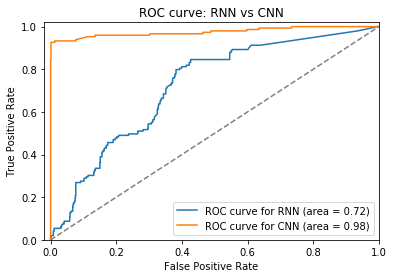

In [32]:
# calculate roc curves
fpr_rnn, tpr_rnn, _ = roc_curve(target, rnn_test)
fpr_cnn, tpr_cnn ,_ = roc_curve(target, cnn_test)

plt.plot(fpr_rnn, tpr_rnn, label='ROC curve for RNN (area = %0.2f)' % auc(fpr_rnn,tpr_rnn))
plt.plot(fpr_cnn, tpr_cnn, label='ROC curve for CNN (area = %0.2f)' % auc(fpr_cnn,tpr_cnn))
plt.plot([0, 1], [0, 1], color='gray',linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve: RNN vs CNN')
plt.legend(loc="lower right")
plt.show()